In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import random
import joblib
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.transforms import ToTensor
from tqdm import tqdm


In [2]:
file = './data/level3/sample'
file_problem = file + '.jpg'
img = cv2.imread(file_problem, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

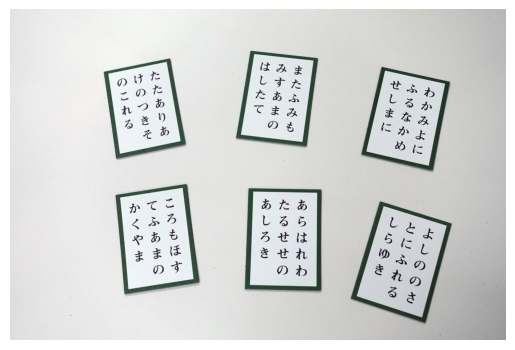

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
#ぼかし処理
blur = cv2.GaussianBlur(gray, None, 3.0)

In [5]:
# 大津の二値化
thr, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

In [6]:
edge = cv2.Canny(binary, 150, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype))

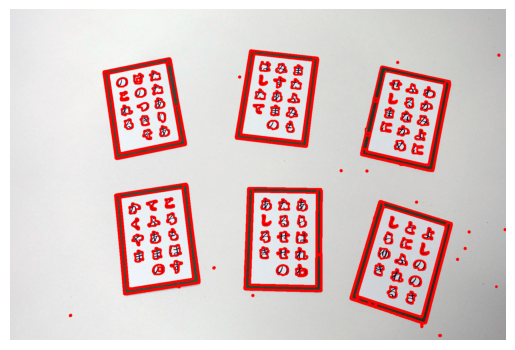

In [7]:
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

result = img.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.axis('off')
plt.show()

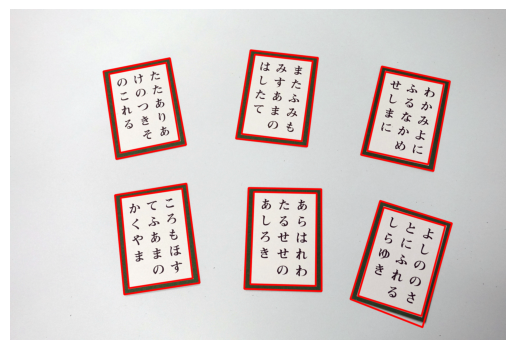

In [8]:
# 輪郭線の検出
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# ノイズ除去の閾値
min_arclen = 400  # 最小の周囲の長さ

# 四角形の条件: 頂点が4つ & 凸形状
square_contours = []
square_index = []

for i, contour in enumerate(contours):
    if cv2.arcLength(contour, True) > min_arclen:  # 周囲の長さがmin_arclenより大きい場合
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # 四角形条件
        if len(approx) == 4 and cv2.isContourConvex(approx):
            square_contours.append(approx)
            square_index.append(i)

# 輪郭線の長さの中央値を計算
arclens = [cv2.arcLength(contour, True) for contour in square_contours]
median_arclen = np.median(arclens)

# 閾値の設定
upper_bound = median_arclen + 0.3 * median_arclen
lower_bound = median_arclen - 0.3 * median_arclen

# さらに、長さが中央値±30%の範囲にある輪郭線を抽出
filtered_contours = []
filtered_index = []

for i, contour in enumerate(square_contours):
    arclen = cv2.arcLength(contour, True)
    if lower_bound <= arclen <= upper_bound:
        filtered_contours.append(contour)
        filtered_index.append(square_index[i])  # 元の contours におけるインデックス

# 候補の輪郭を描画
result = img.copy()
cv2.drawContours(result, filtered_contours, -1, (0, 0, 255), 3, cv2.LINE_AA)

# 結果を表示
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [9]:
# final_contours を格納するリスト
final_contours = []

# filtered_index の各要素について処理
for idx in filtered_index:
    include_in_final = True  # final_contours に含めるフラグ
    stack = [idx]  # 調査するインデックスのスタック

    # 子輪郭線全体を探索
    while stack:
        current_idx = stack.pop()

        # 子輪郭線を調査
        child_idx = hierarchy[0][current_idx][2]
        while child_idx != -1:  # 子が存在する限り
            # 子が filtered_index に存在するか確認
            if child_idx in filtered_index:
                include_in_final = False
                break

            # 次の子をスタックに追加
            stack.append(child_idx)
            # 次の兄弟に移動
            child_idx = hierarchy[0][child_idx][0]

        if not include_in_final:
            break

    # 子が filtered_index に含まれていない場合のみ final_contours に追加
    if include_in_final:
        final_contours.append(contours[idx])

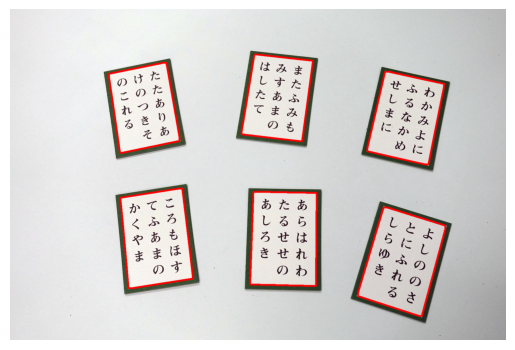

In [10]:
# 候補の輪郭を描画
result = img.copy()
cv2.drawContours(result, final_contours, -1, (0, 0, 255), 3, cv2.LINE_AA)

# 結果を表示
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
# 各頂点が以下の順序で並んでいることを確認します：
# 左上、右上、右下、左下
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    # 合計値が最小の点が左上、最大の点が右下
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # 左上
    rect[2] = pts[np.argmax(s)]  # 右下

    # 差分が最小の点が右上、最大の点が左下
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # 右上
    rect[3] = pts[np.argmax(diff)]  # 左下

    return rect

In [12]:
# 射影変換を適用した結果を格納するリスト
results = []

for cnt in final_contours:

    # 輪郭を近似して多角形を得る
    approx = cv2.approxPolyDP(cnt, arclen * 0.1, True)

    # 頂点を正しい順序に並べ替え
    src_pts = order_points(approx.reshape((-1, 2)).astype("float32"))

    # 縦横比の計算
    w = np.linalg.norm(src_pts[1] - src_pts[0])  # 右上 - 左上
    h = np.linalg.norm(src_pts[3] - src_pts[0])  # 左下 - 左上
    aspect = abs(w) / abs(h)

    # 新しい画像サイズを設定
    new_w = int(1000 * aspect)
    new_h = 1000

    # 射影変換先の座標 (左上、右上、右下、左下)
    dst_pts = np.array([(0, 0), (new_w, 0), (new_w, new_h), (0, new_h)], dtype="float32")

    # 射影変換を計算して、パースをキャンセルする
    warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
    result = cv2.warpPerspective(img, warp, (new_w, new_h))

    # 横幅が縦幅より長い場合は90度回転
    if new_w > new_h:
        result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    # 結果をリストに追加
    results.append(result)

In [13]:
all_cells = []  # すべての画像を格納するリスト

for result in results:
    # Step 1: 大津の二値化を適用
    gray_ = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    gray_ = cv2.GaussianBlur(gray_, None, 3.0)
    _, binary_ = cv2.threshold(gray_, 0, 255, cv2.THRESH_OTSU)

    # Step 2: 上下1/12、左右1/10を削る
    h, w = binary_.shape
    top = h // 14
    bottom = h - h // 14
    left = w // 12
    right = w - w // 12
    cropped = binary_[top:bottom, left:right]

    # Step 3: セル分割用の設定
    cell_height = cropped.shape[0] // 5  # 垂直方向5等分
    cell_width = cropped.shape[1] // 3   # 水平方向3等分

    # セルの拡大倍率
    scale = 1.1
    new_cell_height = int(cell_height * scale)
    new_cell_width = int(cell_width * scale)

    # 縦読み順で格納する
    cells = []
    for col in range(3 - 1, -1, -1):  # 右列から順に
        for row in range(5):  # 各列を上から下へ
            # セルの中心位置
            center_x = int((col + 0.5) * cell_width)
            center_y = int((row + 0.5) * cell_height)
            
            # 拡大したセルの範囲
            x1 = max(0, center_x - new_cell_width // 2)
            x2 = min(cropped.shape[1], center_x + new_cell_width // 2)
            y1 = max(0, center_y - new_cell_height // 2)
            y2 = min(cropped.shape[0], center_y + new_cell_height // 2)
            
            # セルを切り出し
            cell = cropped[y1:y2, x1:x2]
            cells.append(cell)
    # Step 4: リストに格納
    all_cells.append(cells)


In [14]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(16)
        self.fc3 = nn.Linear(1024, out_channels)  # 修正ポイント

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.reshape((x.size(0), -1))  # 出力を平坦化
        x = self.fc3(x)  # 全結合層に入力
        y = F.log_softmax(x, dim=1)
        return y

In [15]:
idx_to_label = {0: 'あ', 1: 'い', 2: 'う', 3: 'え', 4: 'お', 5: 'か', 6: 'き', 7: 'く', 8: 'け', 9: 'こ', 10: 'さ', 11: 'し', 12: 'す', 13: 'せ', 14: 'そ', 15: 'た', 16: 'ち', 17: 'つ', 18: 'て', 19: 'と', 20: 'な', 21: 'に', 22: 'ぬ', 23: 'ね', 24: 'の', 25: 'は', 26: 'ひ', 27: 'ふ', 28: 'へ', 29: 'ほ', 30: 'ま', 31: 'み', 32: 'む', 33: 'め', 34: 'も', 35: 'や', 36: 'ゆ', 37: 'よ', 38: 'ら', 39: 'り', 40: 'る', 41: 'れ', 42: 'ろ', 43: 'わ', 44: 'ゐ', 45: 'ゑ', 46: 'を', 47: 'ん', 48: 'null'}
n_classes = len(idx_to_label)
print(n_classes)

49


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# ネットワークとオプティマイザの別インスタンスを作成
model = CNN(1, n_classes)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# 学習済みパラメータの読み込み
ckpt= torch.load("ckpt.pth", map_location=torch.device("cpu"))
model.load_state_dict(ckpt["model"])
optim.load_state_dict(ckpt["optim"])

In [18]:
model.eval()

# 予測結果を処理する関数
def process_predictions(lists):
    
    all_predictions = []

    for list in lists:
        
        # 各画像をリサイズ
        resized = [cv2.resize(img, (64, 64))/ 255.0 for img in list]

        # 画像をテンソル形式に変換 (N, C, H, W)
        X = np.array(resized, dtype=np.float32)
        X = X[:, np.newaxis, :, :]  # チャネル次元を追加 (グレースケールの場合)
        X = torch.tensor(X, device=device)

        # モデルで予測
        with torch.no_grad():
            logits = model(X)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

        # ラベルに変換し、nullを無視して文字列に結合
        predictions_labels = [idx_to_label[idx] for idx in predictions]
        predictions_texts = "".join(label for label in predictions_labels if label != 'null')

        # サブリストの結果を保存
        all_predictions.append(predictions_texts)

    return all_predictions

In [19]:
# 処理実行
all_cells_predictions = process_predictions(all_cells)

In [20]:
all_cells_predictions

['よしののさとにやれゐしつゆま',
 'あらよれわたるせせのあしろま',
 'ころもはすてやあまのかくよま',
 'わかみよにやるなかめせしまに',
 'たためりあけのつまそのへれる',
 'またふみもみすめまのよしたて']

In [21]:
ogura = pd.read_csv('./data/ogura.csv', header=None)
ogura

,0,1,2,3,4,5
0,1,あきのたの,かりほのいほの,とまをあらみ,わかころもては,つゆにぬれつつ
1,2,はるすきて,なつきにけらし,しろたへの,ころもほすてふ,あまのかくやま
2,3,あしひきの,やまとりのをの,したりをの,なかなかしよを,ひとりかもねむ
3,4,たこのうらに,うちいててみれは,しろたへの,ふしのたかねに,ゆきはふりつつ
4,5,おくやまに,もみちふみわけ,なくしかの,こゑきくときそ,あきはかなしき
...,...,...,...,...,...,...
95,96,はなさそふ,あらしのにはの,ゆきならて,ふりゆくものは,わかみなりけり
96,97,こぬひとを,まつほのうらの,ゆふなきに,やくやもしほの,みもこかれつつ
97,98,かせそよく,ならのをかはの,ゆふくれは,みそきそなつの,しるしなりける
98,99,ひともをし,ひともうらめし,あちきなく,よをおもふゆゑに,ものおもふみは


In [22]:
# 結果を格納するリスト
ogura_upper = []
ogura_lower = []

# 一致文字数を計算する関数
def count_matches(prediction, text1, text2):
    combined = text1 + text2
    return sum(1 for char in prediction if char in combined)

# 処理
for prediction in all_cells_predictions:
    # 一致文字数が最大の行を見つける
    best_row = ogura.iloc[
        ogura.apply(
            lambda row: max(
                count_matches(prediction, row[4], row[5]),  # そのままのpredictionとの一致
                count_matches(prediction[::-1], row[4], row[5])  # 逆のpredictionとの一致
            ), 
            axis=1
        ).idxmax()
    ]
    
    # インデックス1,2,3列目をまとめてリストに追加
    ogura_upper.append(''.join([best_row[1], best_row[2], best_row[3]]))
    # インデックス4,5列目をまとめてリストに追加
    ogura_lower.append(''.join([best_row[4], best_row[5]]))

# 結果の出力
print("ogura_upper:", ogura_upper)
print("ogura_lower:", ogura_lower)

ogura_upper: ['あさほらけありあけのつきとみるまてに', 'あさほらけうちのかはきりたえたえに', 'はるすきてなつきにけらししろたへの', 'はなのいろはうつりにけりないたつらに', 'ほとときすなきつるかたをなかむれは', 'おほえやまいくののみちのとほけれは']
ogura_lower: ['よしののさとにふれるしらゆき', 'あらはれわたるせせのあしろき', 'ころもほすてふあまのかくやま', 'わかみよにふるなかめせしまに', 'たたありあけのつきそのこれる', 'またふみもみすあまのはしたて']


In [23]:
poems = [
    'はなのいろはうつりにけりないたつらに',
    'あきのたのかりほのいほのとまをあらみ',
    'あさほらけありあけのつきとみるまてに',
    'はるすきてなつきにけらししろたへの',
    'ほとときすなきつるかたをなかむれは'
]

In [24]:
def calculate_decisive_character(poem, ogura_upper):
    # ogura_upper内に該当する文字列がなければ0を返す
    if poem not in ogura_upper:
        return 0
    
    # ogura_upper内の対象文字列以外をフィルタ
    target_strings = [s for s in ogura_upper if s != poem]
    
    # 文字ごとに比較し、違いが確定する位置を計算
    for i in range(1, len(poem) + 1):
        prefix = poem[:i]  # 決まり字候補
        if all(not s.startswith(prefix) for s in target_strings):
            return i  # 決まり字が確定する位置を返す
    
    # 決まり字が全く確定しない場合
    return len(poem)

# poemsに対する処理
answer = [
    (calculate_decisive_character(poem, ogura_upper), poem if calculate_decisive_character(poem, ogura_upper) != 0 else "")
    for poem in poems
]

# 結果の出力
print("Answer:", answer)

Answer: [(2, 'はなのいろはうつりにけりないたつらに'), (0, ''), (6, 'あさほらけありあけのつきとみるまてに'), (2, 'はるすきてなつきにけらししろたへの'), (1, 'ほとときすなきつるかたをなかむれは')]
